In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [154]:
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']

ratings = pd.read_csv("ml-100k/u.data", sep="\t", names=r_cols, encoding='latin-1')

ratings.head()

ratings.describe()

,user_id,movie_id,rating,timestamp
count,100000.00000,100000.000000,100000.000000,1.000000e+05
mean,462.48475,425.530130,3.529860,8.835289e+08
std,266.61442,330.798356,1.125674,5.343856e+06
min,1.00000,1.000000,1.000000,8.747247e+08
25%,254.00000,175.000000,3.000000,8.794487e+08
50%,447.00000,322.000000,4.000000,8.828269e+08
75%,682.00000,631.000000,4.000000,8.882600e+08
max,943.00000,1682.000000,5.000000,8.932866e+08


In [155]:
i_cols = ['movie_id', 'title' ,'release date','video release date', 'IMDb URL', 'unknown', 'Action', 'Adventure',
'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 'Drama', 'Fantasy',
'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']

movies = pd.read_csv('ml-100k/u.item',  sep='|', names=i_cols, encoding='latin-1')

movies.head()

,movie_id,title,release date,video release date,IMDb URL,unknown,Action,Adventure,Animation,Children's,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [156]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('ml-100k/u.user', sep='|', names=u_cols, encoding='latin-1')

users.head()

,user_id,age,sex,occupation,zip_code
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


In [157]:
num_users = len(users)
num_movies = len(movies)
print(num_users)
print(num_movies)

print(len(ratings.user_id.unique()))
print(len(ratings.movie_id.unique()))

sparsity = 1 - len(ratings) / (num_users * num_movies)

print(f"Sparsity: {sparsity:.3f}")

943
1682
943
1682
Sparsity: 0.937


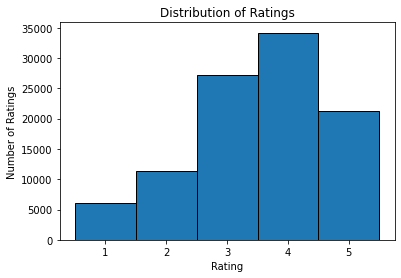

In [158]:
plt.hist(ratings.rating, ec='black', bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
plt.xlabel("Rating")
plt.ylabel("Number of Ratings")
plt.title("Distribution of Ratings")
plt.xticks([1, 2, 3, 4, 5])
plt.show()

In [159]:
rating_matrix = ratings.pivot(index="user_id", columns="movie_id", values="rating").fillna(0)
matrix = pd.DataFrame(rating_matrix.values)

print(matrix.shape)
print(matrix.iloc[:5, :5])
print(matrix.iloc[:5, :5].describe())

sparsity = 1 - np.count_nonzero(matrix) / (num_users * num_movies)
print(f"Sparsity: {sparsity:.3f}")

(943, 1682)
     0    1    2    3    4
0  5.0  3.0  4.0  3.0  3.0
1  4.0  0.0  0.0  0.0  0.0
2  0.0  0.0  0.0  0.0  0.0
3  0.0  0.0  0.0  0.0  0.0
4  4.0  3.0  0.0  0.0  0.0
              0         1         2         3         4
count  5.000000  5.000000  5.000000  5.000000  5.000000
mean   2.600000  1.200000  0.800000  0.600000  0.600000
std    2.408319  1.643168  1.788854  1.341641  1.341641
min    0.000000  0.000000  0.000000  0.000000  0.000000
25%    0.000000  0.000000  0.000000  0.000000  0.000000
50%    4.000000  0.000000  0.000000  0.000000  0.000000
75%    4.000000  3.000000  0.000000  0.000000  0.000000
max    5.000000  3.000000  4.000000  3.000000  3.000000
Sparsity: 0.937


In [173]:
U, S, V = np.linalg.svd(matrix)


print(f"U: {pd.DataFrame(U).iloc[:5, :5]}")
print(f"S: {pd.DataFrame(S).iloc[:5, :]}")
print(f"VT: {pd.DataFrame(V.transpose()).iloc[:5, :5]}")

U:           0         1         2         3         4
0 -0.065804  0.005975 -0.006133  0.084347 -0.014188
1 -0.014021 -0.046626  0.052579 -0.016282  0.015467
2 -0.005658 -0.025618  0.023362 -0.028564 -0.044057
3 -0.005993 -0.020698  0.012452 -0.019697 -0.025116
4 -0.032747  0.009159 -0.046131  0.014407 -0.010518
S:             0
0  640.633623
1  244.836346
2  217.846225
3  159.153599
4  158.211914
VT:           0         1         2         3         4
0 -0.095951 -0.087240 -0.016974  0.016206  0.140506
1 -0.035180 -0.007025 -0.062504  0.003234 -0.040758
2 -0.019929 -0.028618 -0.011641  0.048801 -0.004402
3 -0.059952  0.013050 -0.026446  0.043000 -0.038221
4 -0.021607 -0.015311 -0.026460  0.017901 -0.015655
